In [82]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import linear_model
import statsmodels.api as sm
import folium
#%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Будем строить модель для региона #1075 (координаты центра -74.0166906; 40.7016309), в котором находятся набережная, Battery Park и State street.

In [89]:
SL = [40.7016309, -74.0166906];

map1 = folium.Map(location= SL, tiles='Stamen Terrain')
folium.Marker(SL, popup='region #1075').add_to(map1);
map1

In [2]:
startDate = datetime.datetime(2014,1,1,0,0,0);
endDate = datetime.datetime(2016,4,30,23,59,59);

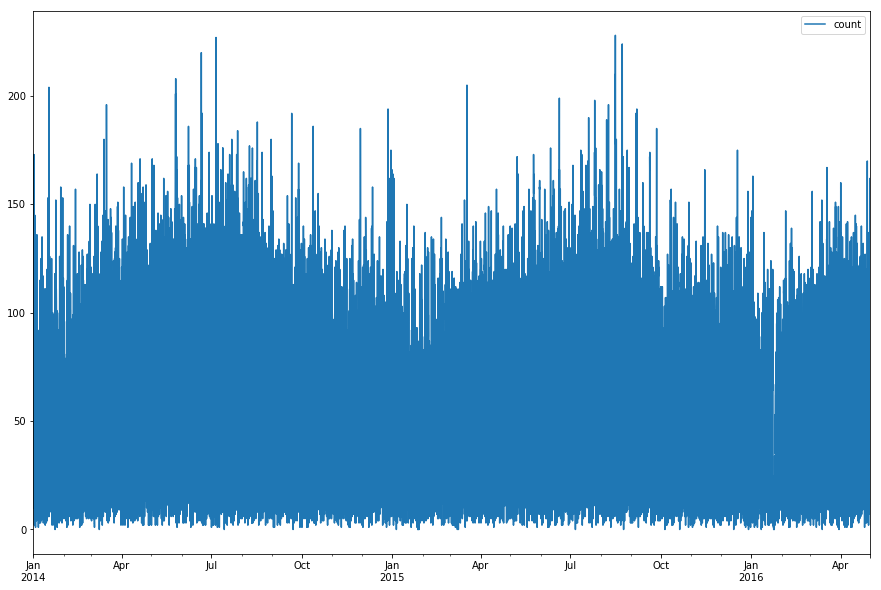

In [4]:
res = pd.read_pickle('../region-1075-2014-16.pcl')
## fill empty hours 
date_index = pd.date_range(startDate, endDate, freq='H')
res = res.reindex(date_index,fill_value =0)
res.plot(figsize = [15,10])

# add linear feature
res = res.assign(hours = (res.index-res.index[0])/np.timedelta64(1, 'h'))

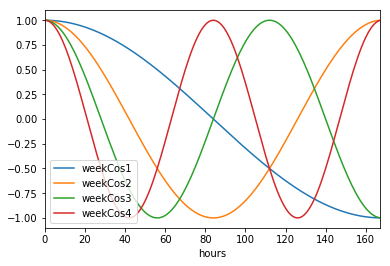

In [5]:
# add week periodicity
K = 6

for ind in range(1,K+1):
    res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
    res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);

res[0:168].plot('hours',['weekCos1','weekCos2','weekCos3','weekCos4']);

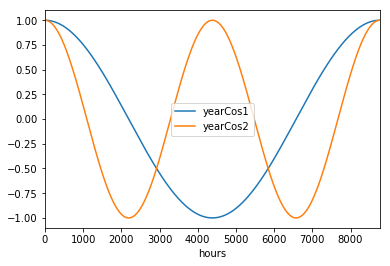

In [6]:
# add annual periodicity
K = 3

for ind in range(1,K+1):
    res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
    res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);

res[0:8766].plot('hours',['yearCos1','yearCos2']);

## Lasso regression

In [7]:
def lassoRegression(df):
    X = df.drop('count',axis = 1);
    y = df.loc[:,'count'];
    lassoReg = linear_model.Lasso(alpha = 0.1, max_iter = 1e5,fit_intercept=True);
    lassoReg.fit(X,y)
    y_pr = pd.Series(data = lassoReg.predict(X), index = df.index)
    R = lassoReg.score(X,y);
    print 'R factor is ', R
    
    plt.figure(figsize = [15,10])
    plt.plot(y)
    plt.plot(y-y_pr)
    plt.legend(['original data','residuals'])
    return [y_pr, y-y_pr] 

R factor is  0.0462158708996


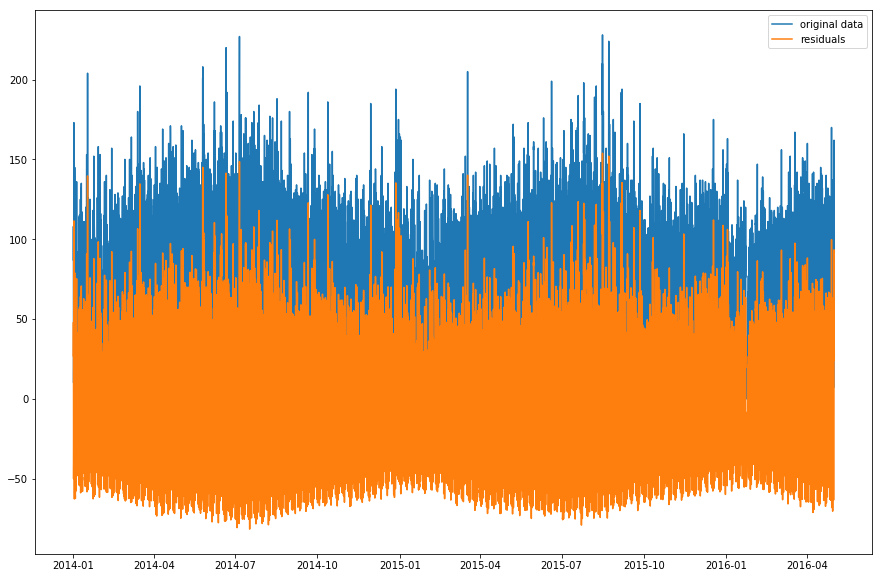

In [8]:
[s1,r1]=lassoRegression(res)

R factor is  0.0501986460163


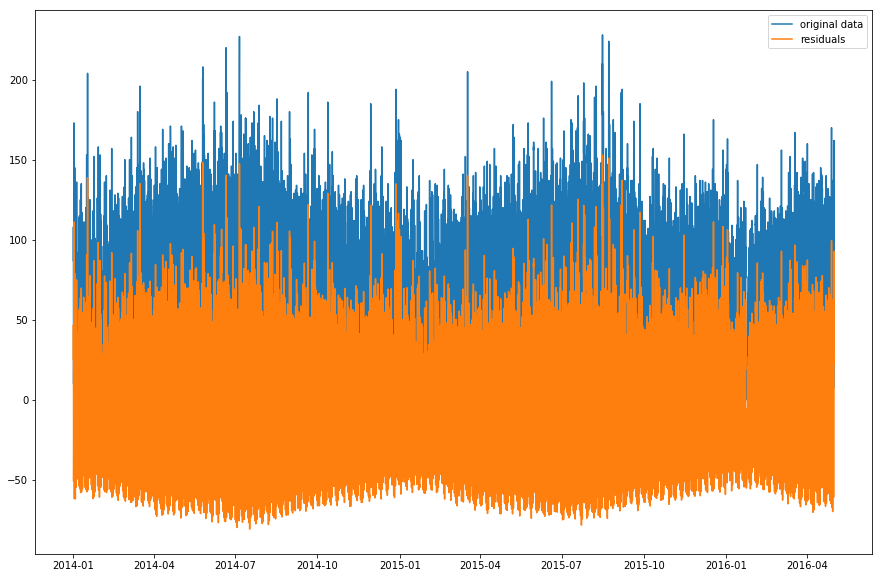

In [9]:
#res.merge() 
DoW = pd.get_dummies(res.index.dayofweek,drop_first= True,prefix = 'dayofWeek');
DoW.index = date_index;
res = res.merge(DoW,left_index=True,right_index=True)
[s2,r2] = lassoRegression(res)

Добавим категориальный признак месяца

R factor is  0.0509938381984


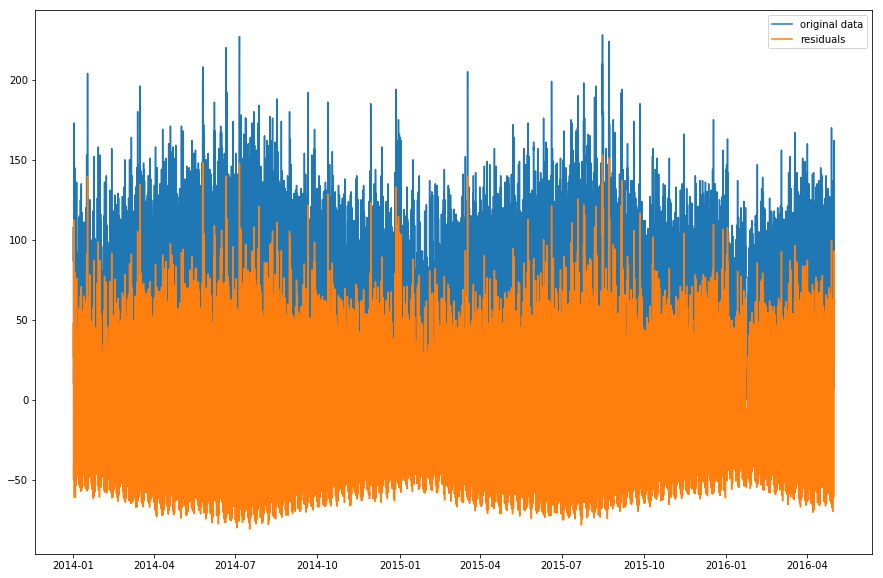

In [10]:
mth = pd.get_dummies(res.index.month,drop_first= True,prefix = 'month');
mth.index = res.index;
res = res.merge(mth,left_index=True,right_index=True);
[s3,r3] = lassoRegression(res);

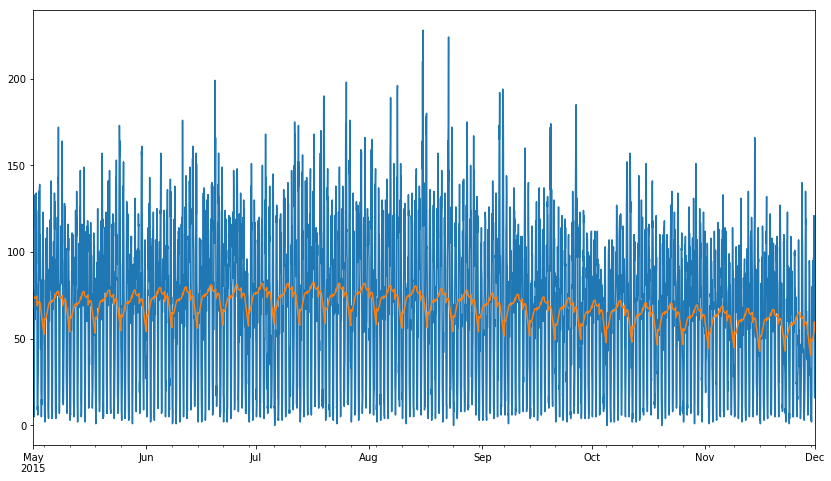

In [11]:
plt.figure(figsize=[14,8])
res['count'].plot();
s3.plot();
plt.xlim(['2015-05-1','2015-12-1']);

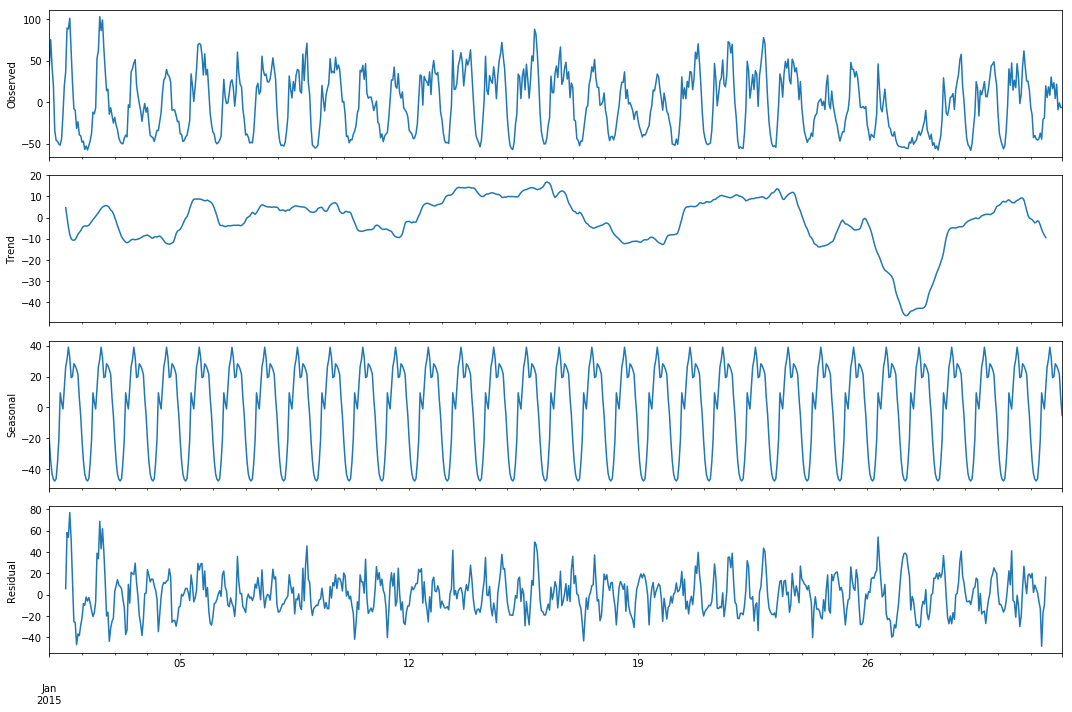

Критерий Дики-Фуллера: p=0.000000


In [12]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(r3['2015-1':'2015-1']).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(res['count'])[1])

Отчётливо видны суточные и недельные колебания

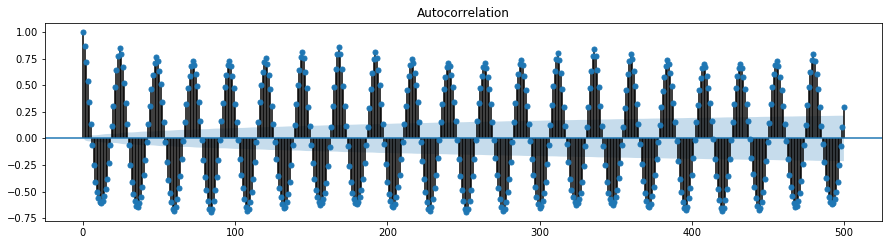

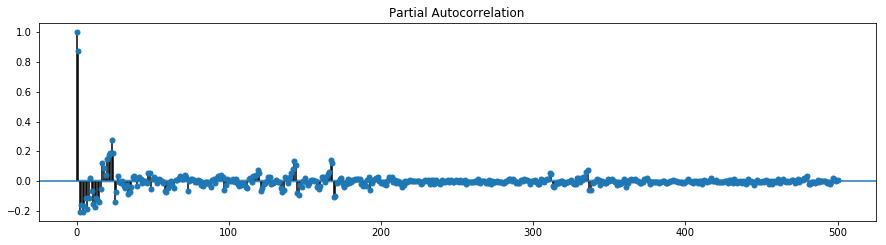

In [13]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r3.values.squeeze(), lags=500, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r3.values.squeeze(), lags=500, ax=ax)
pylab.show()

Дифференцируем с лагом один, чтобы удалить тренд. Хотя его и так нет?

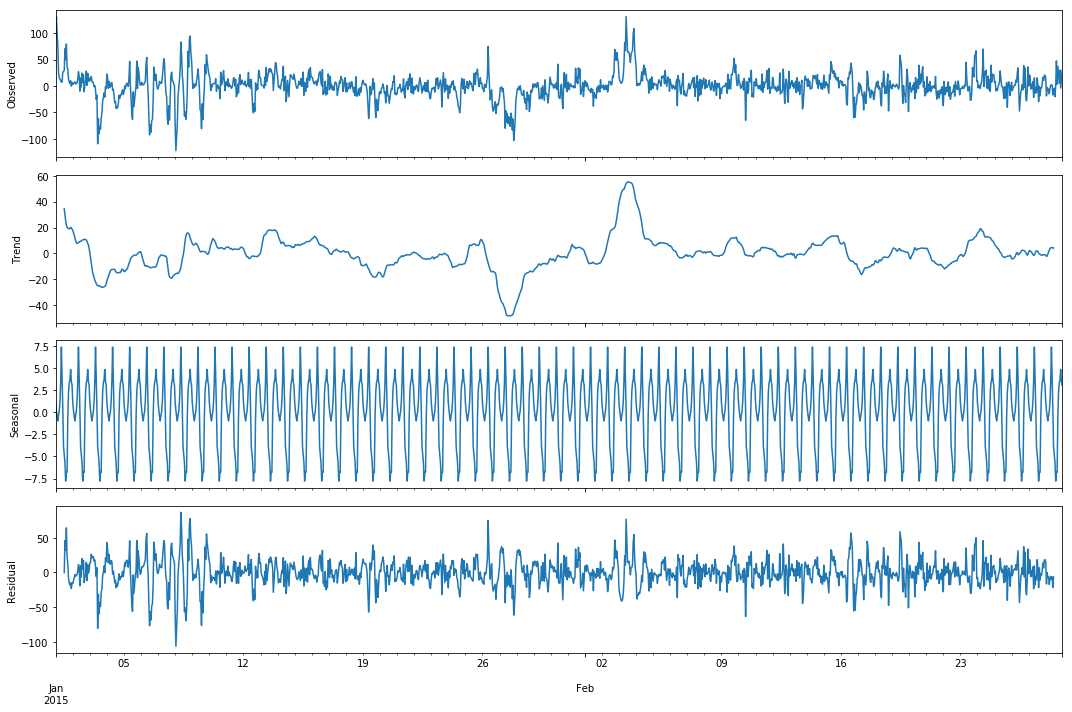

Критерий Дики-Фуллера: p=0.000000


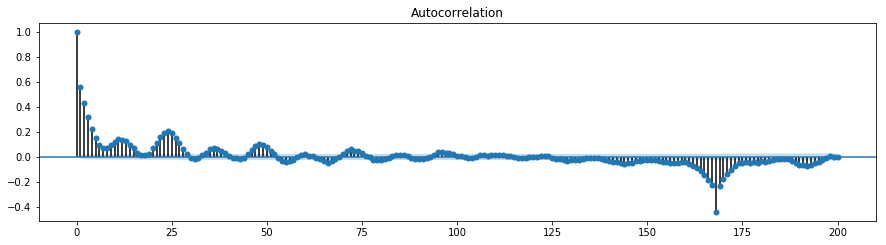

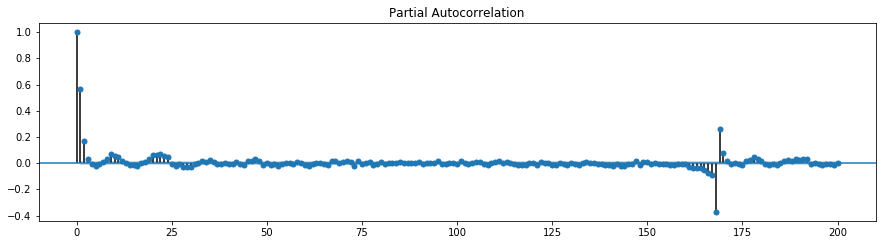

In [14]:
r4 = r3 - r3.shift(168)
r4=r4[np.isfinite(r4)]
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(r4['2015-1':'2015-2']).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(res['count'])[1])

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r4.values.squeeze(), lags=200, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r4.values.squeeze(), lags=200, ax=ax)
pylab.show()

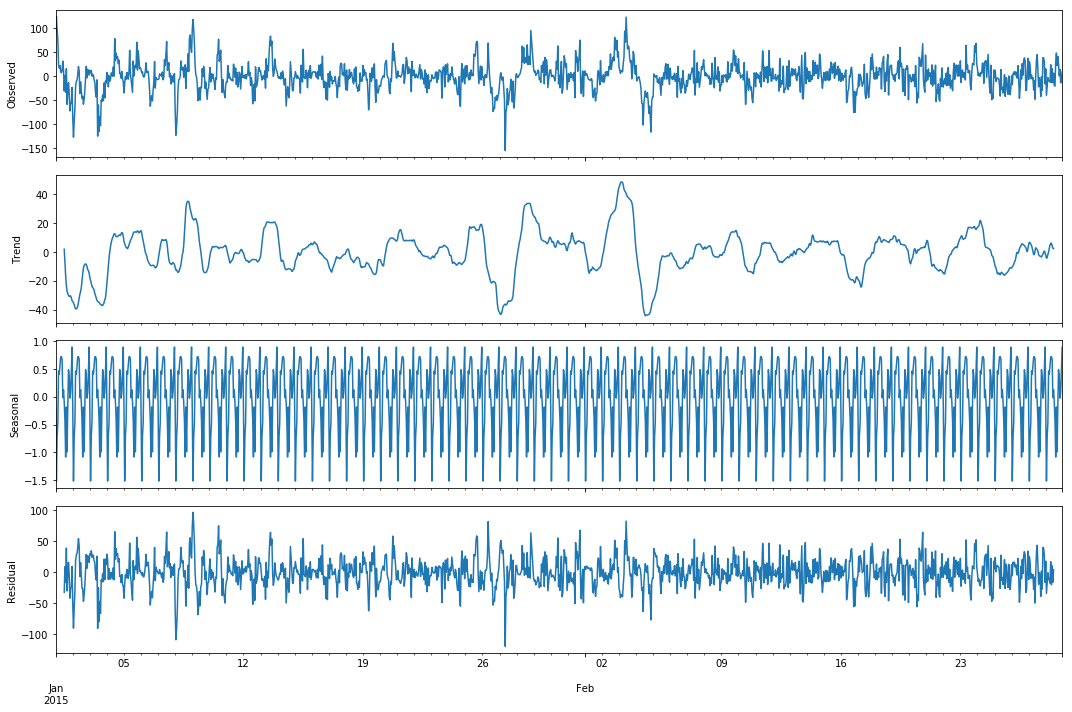

Критерий Дики-Фуллера: p=0.000000


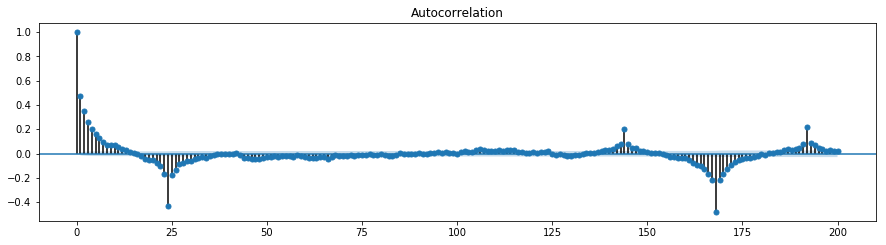

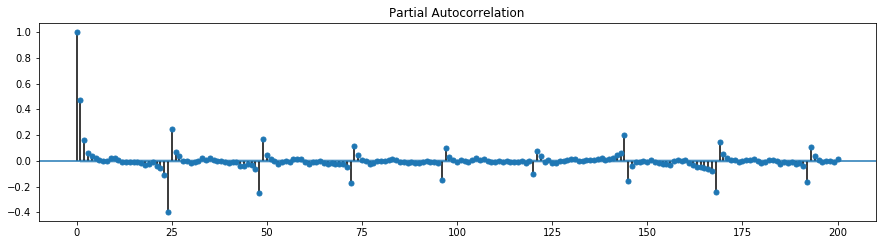

In [15]:
r5 = r4 - r4.shift(24)
r5 = r5[np.isfinite(r5)]
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(r5['2015-1':'2015-2']).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(r5)[1])

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r5, lags=200, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r5, lags=200, ax=ax)
pylab.show()

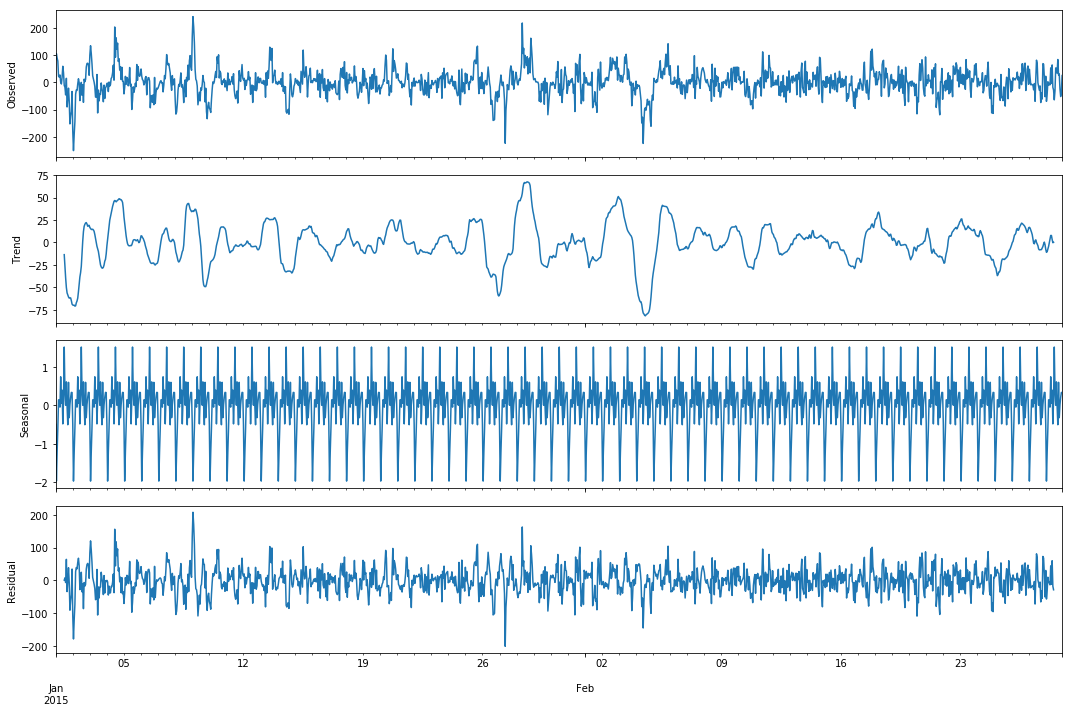

Критерий Дики-Фуллера: p=0.000000


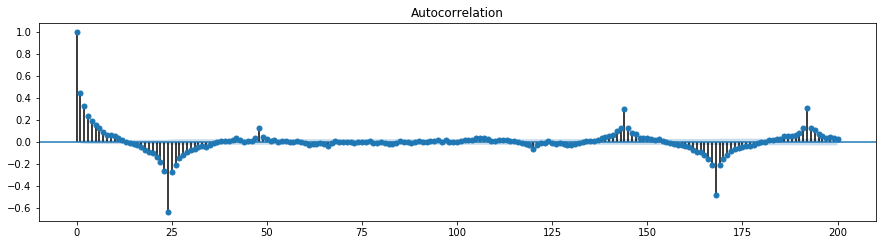

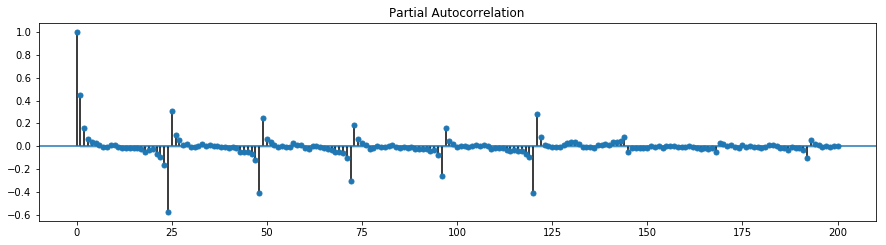

In [16]:
r6 = r5 - r5.shift(24)
r6 = r6[np.isfinite(r6)]
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(r6['2015-1':'2015-2']).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(r5)[1])

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r6, lags=200, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r6, lags=200, ax=ax)
pylab.show()

Итого: будем аппроксимировать моделью SARIMAX ряд res c одним дифференцированием по ближайщим лагам и одним дифференцирование по суточному лагу (порядок лага - 24 часа). В качестве параметра exogen будем передавать результаты регрессии (ряд r3).

In [38]:
from itertools import product
ps = range(20, 24)
d=1
qs = range(20, 24)

Ps = range(1, 3)
D=1
Qs = range(1, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [ ]:
# Обучаем модель
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        mSARIMA=sm.tsa.statespace.SARIMAX(res['count'], order=[param[0], 1, param[1]],
                                          seasonal_order=(param[2], 1, param[3], 24),exog = r3).fit(disp=1);
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = mSARIMA.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = mSARIMA
        best_aic = aic
        best_param = param
    results.append([param, mSARIMA.aic])
    
warnings.filterwarnings('default')

По результатам обучения моделей с разными параметрами (p,q,P,Q), наилучший результат показан для значений (24,21,1,2). Эта модель была сохранена в отдельный файл.

# Результаты моделирования

In [17]:
# загрузим сохранённую модель
mName = '../model_28March2017.pcl'
model = sm.load(mName)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                  
============================================================================================
Dep. Variable:                                count   No. Observations:                21144
Model:             SARIMAX(24, 1, 21)x(1, 1, 2, 24)   Log Likelihood              -85353.250
Date:                              Fri, 21 Apr 2017   AIC                         170806.501
Time:                                      22:26:06   BIC                         171204.456
Sample:                                  01-01-2014   HQIC                        170936.350
                                       - 05-30-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.5093      0.052     29.047      0.000       1.407       1.611
ar.L1         -0.7145      1.991     -0.359      0.720      -4.617       3.188
ar.L2         -0.1885      2.361     -0.080      0.936      -4.816       4.439
ar.L3         -0.0087      1.426     -0.006      0.995      -2.804       2.786
ar.L4          0.0189      0.643      0.029      0.977      -1.241       1.279
ar.L5         -0.0983      0.335     -0.293      0.769      -0.756       0.559
ar.L6         -0.2524      0.436     -0.579      0.563      -1.107       0.602
ar.L7         -0.3139      0.786     -0.399      0.690      -1.855       1.227
ar.L8         -0.2333      1.027     -0.227      0.820      -2.246       1.779
ar.L9         -0.1918      0.920     -0.209      0.835      -1.995       1.611
ar.L10        -0.0841      0.772     -0.109      0.913      -1.596       1.428
ar.L11         0.0606      0.540      0.112      0.911      -0.999       1.120
ar.L12         0.2726      0.255      1.069      0.285      -0.227       0.772
ar.L13         0.2990      0.394      0.759      0.448      -0.473       1.071
ar.L14         0.2873      0.694      0.414      0.679      -1.073       1.648
ar.L15         0.1062      0.865      0.123      0.902      -1.588       1.801
ar.L16         0.0158      0.621      0.025      0.980      -1.201       1.232
ar.L17         0.0926      0.328      0.282      0.778      -0.551       0.736
ar.L18         0.0800      0.344      0.233      0.816      -0.594       0.754
ar.L19        -0.0748      0.322     -0.232      0.816      -0.707       0.557
ar.L20        -0.0699      0.053     -1.328      0.184      -0.173       0.033
ar.L21         0.0703      0.177      0.396      0.692      -0.277       0.418
ar.L22         0.0563      0.074      0.761      0.446      -0.089       0.201
ar.L23         0.1039      0.152      0.685      0.493      -0.193       0.401
ar.L24        -0.0742      0.287     -0.259      0.796      -0.636       0.488
ma.L1          0.2838      1.991      0.143      0.887      -3.619       4.186
ma.L2         -0.2926      1.506     -0.194      0.846      -3.243       2.658
ma.L3         -0.3166      0.170     -1.857      0.063      -0.651       0.017
ma.L4         -0.2486      0.673     -0.370      0.712      -1.567       1.070
ma.L5         -0.0498      0.766     -0.065      0.948      -1.551       1.451
ma.L6          0.1361      0.382      0.356      0.722      -0.612       0.885
ma.L7          0.1152      0.230      0.500      0.617      -0.336       0.567
ma.L8         -0.0949      0.340     -0.279      0.780      -0.761       0.571
ma.L9         -0.1029      0.195     -0.529      0.597      -0.484       0.279
ma.L10        -0.0809      0.347     -0.233      0.816      -0.761       0.599
ma.L11        -0.0969      0.340     -0.285      0.775      -0.762       0.569
ma.L12        -0.2402      0.297  

In [32]:
# делаем предсказание
pr = model.predict()
r = res['count']

Сравним результаты наблюдений и предсказаний для нескольких временных интервалов

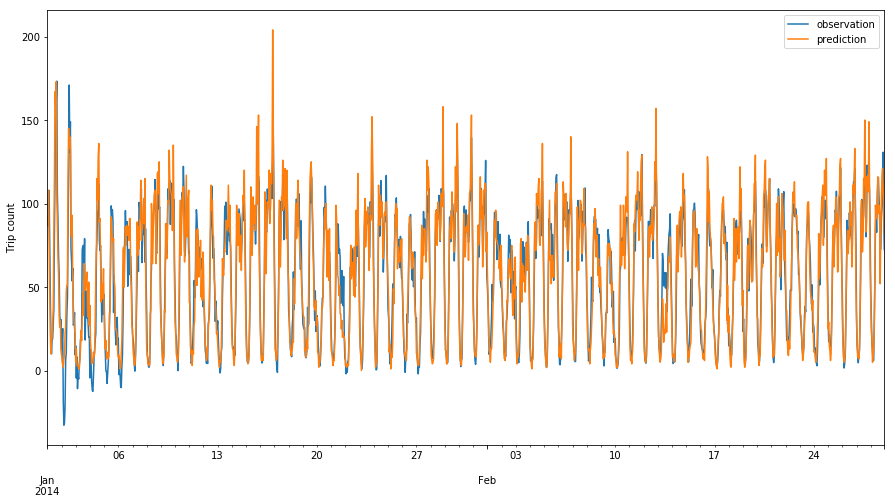

In [42]:
pr['2014-1':'2014-2'].plot()
r['2014-1':'2014-2'].plot()
plt.legend(['observation','prediction'])
plt.ylabel('Trip count')

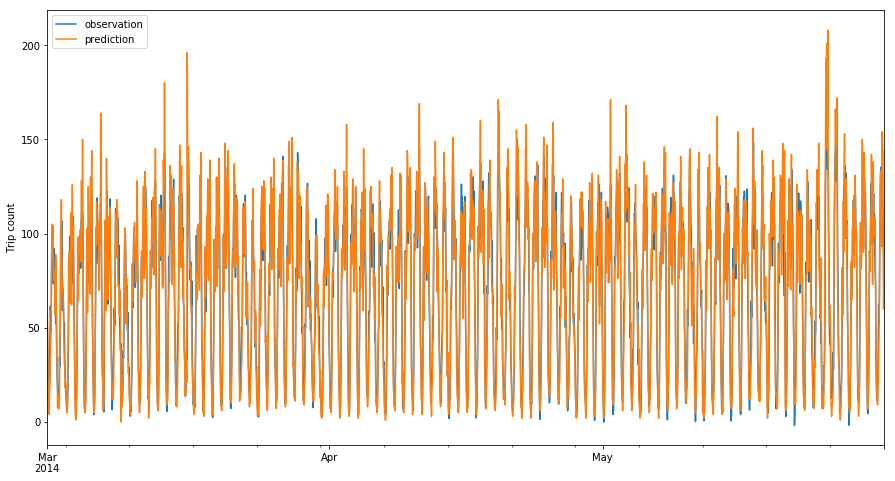

In [43]:
pr['2014-3':'2014-5'].plot()
r['2014-3':'2014-5'].plot()
plt.legend(['observation','prediction'])
plt.ylabel('Trip count')

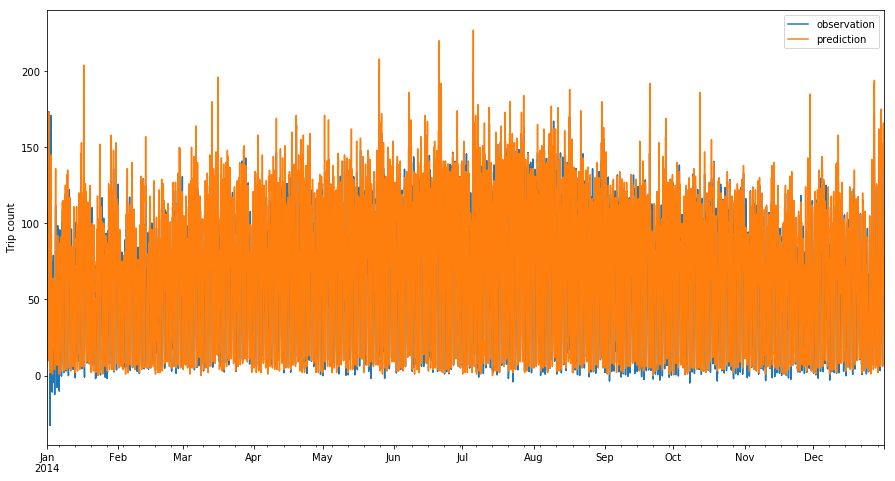

In [44]:
pr['2014'].plot()
r['2014'].plot()
plt.legend(['observation','prediction'])
plt.ylabel('Trip count')

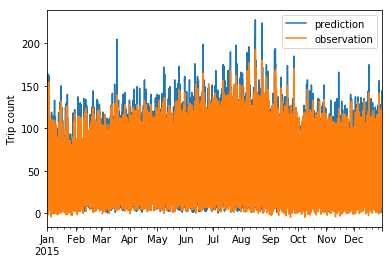

In [91]:
r['2015'].plot()
pr['2015'].plot()
plt.legend(['prediction','observation'])
plt.ylabel('Trip count')

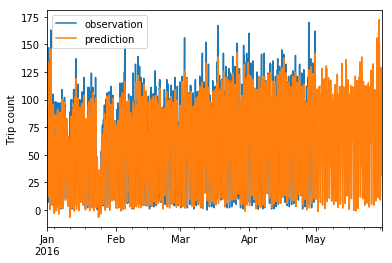

In [90]:
r['2016'].plot()
pr['2016'].plot()
plt.legend(['observation','prediction'])
plt.ylabel('Trip count')

Построим ошибку предсказаний

In [60]:
err = pr-r

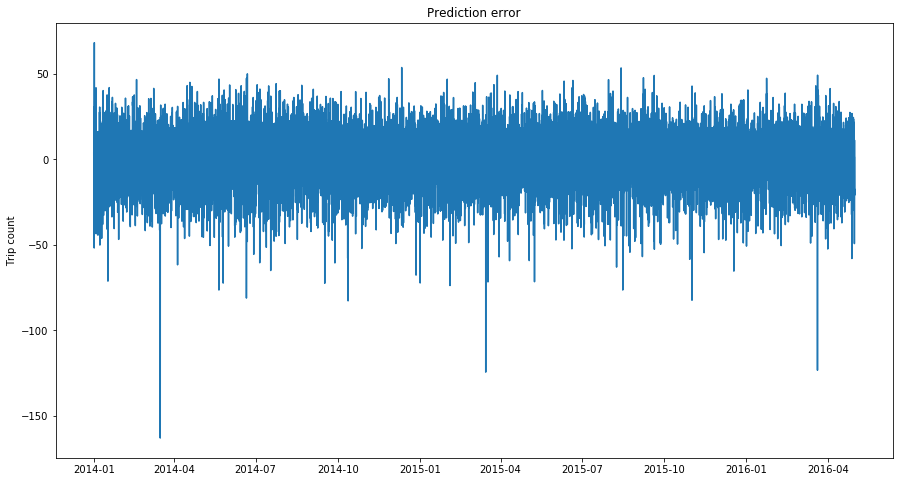

In [62]:
plt.plot(err)
plt.ylabel('Trip count')
plt.title('Prediction error')

Отчётливо видны три пика, приходящиеся на середину апрель. В эти даты предсказание даёт существенно меньшие значения.

(736038.0, 736044.0)

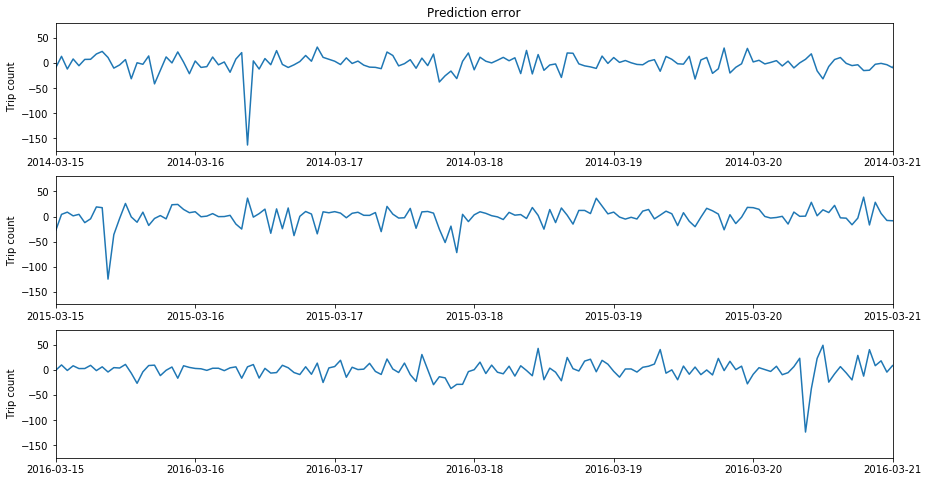

In [75]:
plt.subplot(311)
plt.plot(err)
plt.ylabel('Trip count')
plt.title('Prediction error')
plt.xlim(['2014-03-15','2014-03-21'])

plt.subplot(312)
plt.plot(err)
plt.ylabel('Trip count')
plt.xlim(['2015-03-15','2015-03-21'])

plt.subplot(313)
plt.plot(err)
plt.ylabel('Trip count')
plt.xlim(['2016-03-15','2016-03-21'])

В 2014 году пик приходит на 16 марта, в 2015 году - на 15 марта, в 2016 году - на 20 марта. В каждом году это третье воскресенье марта и все три пика приходятся на 9 утра. Мне не удалось выяснить, с чем связан этот пик.

В целом, построенная модель достаточно хорошо описывает наблюдаем временной ряд.

In [ ]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(err, lags=200, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(e, lags=200, ax=ax)
pylab.show()